In [4]:
import csv
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import descartes
from shapely.geometry import Point, Polygon
import adjustText as aT

#Load in the CSV Bike Station Location Data
df = pd.read_csv('HRSQ12020.csv')

#combine the latitude and longitude to make coordinates
df['coordinates'] = df[['Longitude', 'Latitude']].values.tolist()

# Change the coordinates to a geoPoint
df['coordinates'] = df['coordinates'].apply(Point)

#fixing wrong negative value for Latitude
df.loc[df["Latitude"] == df["Latitude"].min()]
df.at[80, 'Latitude'] = 40.467715

In [5]:
#plot the pittsburgh neighborhoods map
pittMap = gpd.read_file('Neighborhoods/ecc95d19-e9fb-46a3-be05-e7e103f362a52020328-1-565pof.jnegf.shp')

#find the centroids of each neighborhood for labeling
pittMap["center"] = pittMap["geometry"].centroid
map_points = pittMap.copy()
map_points.set_geometry("center", inplace = True)
map_points.head()

,objectid,fid_blockg,statefp10,countyfp10,tractce10,blkgrpce10,geoid10,namelsad10,mtfcc10,funcstat10,...,page_numbe,plannerass,created_us,created_da,last_edite,last_edi_1,Shape__Are,Shape__Len,geometry,center
0,1,0.0,42,003,040500,1,420030405001,Block Group 1,G5030,S,...,15,Derek Dauphin,pgh.admin,1571840236403,pgh.admin,1571840236403,7.842997e+06,11525.904546,"POLYGON ((-79.95304 40.44203, -79.95302 40.442...",POINT (-79.95465 40.43862)
1,2,1.0,42,003,040400,1,420030404001,Block Group 1,G5030,S,...,15,Derek Dauphin,pgh.admin,1571840236403,pgh.admin,1571840236403,1.390469e+07,20945.562570,"POLYGON ((-79.95455 40.45882, -79.95427 40.458...",POINT (-79.95356 40.44828)
2,3,2.0,42,003,040200,2,420030402002,Block Group 2,G5030,S,...,15,Derek Dauphin,pgh.admin,1571840236403,pgh.admin,1571840236403,5.998649e+06,18280.484515,"POLYGON ((-79.96230 40.44294, -79.96220 40.442...",POINT (-79.96608 40.44023)
3,4,3.0,42,003,030500,2,420030305002,Block Group 2,G5030,S,...,15,Derek Dauphin,pgh.admin,1571840236403,pgh.admin,1571840236403,7.203337e+06,15697.914337,"POLYGON ((-79.98275 40.44641, -79.98273 40.446...",POINT (-79.98379 40.44274)
4,5,5.0,42,003,020300,1,420030203001,Block Group 1,G5030,S,...,15,Andrea Lavin Kossis,pgh.admin,1571840236403,pgh.admin,1571840236403,1.694875e+07,24019.532672,"POLYGON ((-79.97494 40.45629, -79.97484 40.456...",POINT (-79.98100 40.45383)


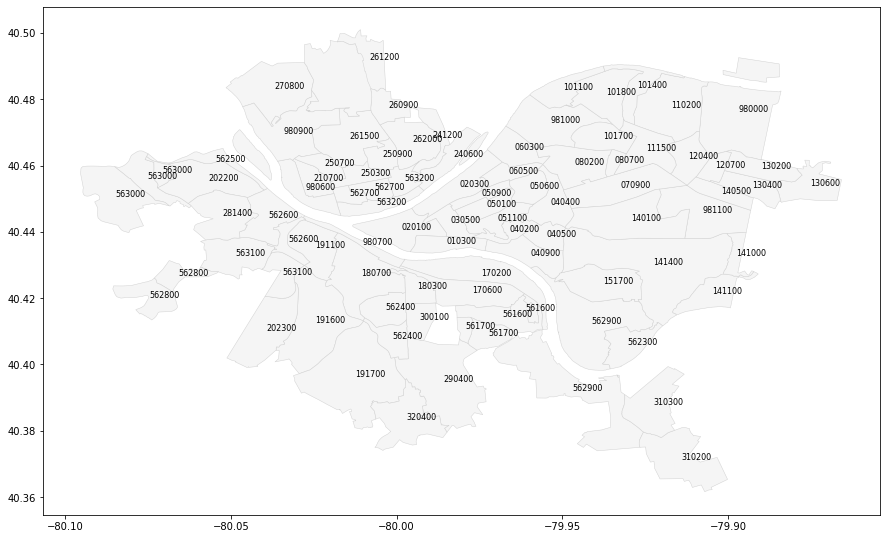

In [14]:
#plot the neighborhood ids on the map
ax = pittMap.plot(figsize = (15, 12), color = "whitesmoke", edgecolor = "lightgrey", linewidth = 0.5)
texts = []

for x, y, label in zip(map_points.geometry.x, map_points.geometry.y, map_points["tractce10"]):
    texts.append(plt.text(x, y, label, fontsize = 8))

#aT.adjust_text(texts, force_points=0.3, force_text=0.8, expand_points=(1,1), expand_text=(1,1), arrowprops=dict(arrowstyle="-", color='grey', lw=0.5))

In [15]:
#find the neighborhood ids that are in Pittsburgh and drop the 'None' cell
col_ID_list = pittMap['tractce10'].tolist()
columns = ['Neighborhoods']
iddf = pd.DataFrame(col_ID_list, columns=columns)

In [36]:
iddf = iddf.drop(iddf.index[89])

In [43]:
#Add those neighborhood ids to a set - we have 88 neighborhoods
setIDs = set([])
for index, row in iddf.iterrows():
      setIDs.add(row['Neighborhoods'])

In [97]:
#Load in the CSV poor housing neighborhoods data
housingdf = pd.read_csv('poorhousingconditions.csv')
#get only the neighborhood IDs that match to the Pittsburgh Neighborhood Map
housingdf = housingdf[housingdf.TRACT != 0]
#change the neighborhood ids to be strings and have a 0 in front to match the other df output
houseSet = set([])
for index, row in housingdf.iterrows():
    strVal = str(row['TRACT'])
    strVals = strVal.split(".")
    if len(strVals[0]) < 6:
        strVals[0] = "0" + strVals[0]
    houseSet.add(strVals[0])
    
#make a new df with the new type as string
columns = ['tractce10']
newIDdf = pd.DataFrame(houseSet, columns=columns)
newIDdf['poorCon'] = housingdf['PPoorCon']

In [101]:
#filter poor housing neighborhoods data by specified neighborhood ids
for index, row in newIDdf.iterrows():
    if row['tractce10'] not in setIDs:
        newIDdf = newIDdf[newIDdf.tractce10 != row['tractce10']]
len(newIDdf)

75

In [107]:
#prep two merge the geodataframe and the dataframe together
pdf = pittMap.drop(pittMap.index[89])
pdf = pdf.merge(newIDdf, on='tractce10')
pdf.head()

,objectid,fid_blockg,statefp10,countyfp10,tractce10,blkgrpce10,geoid10,namelsad10,mtfcc10,funcstat10,...,plannerass,created_us,created_da,last_edite,last_edi_1,Shape__Are,Shape__Len,geometry,center,poorCon
0,1,0.0,42,003,040500,1,420030405001,Block Group 1,G5030,S,...,Derek Dauphin,pgh.admin,1571840236403,pgh.admin,1571840236403,7.842997e+06,11525.904546,"POLYGON ((-79.95304 40.44203, -79.95302 40.442...",POINT (-79.95465 40.43862),0.003162
1,2,1.0,42,003,040400,1,420030404001,Block Group 1,G5030,S,...,Derek Dauphin,pgh.admin,1571840236403,pgh.admin,1571840236403,1.390469e+07,20945.562570,"POLYGON ((-79.95455 40.45882, -79.95427 40.458...",POINT (-79.95356 40.44828),0.012838
2,3,2.0,42,003,040200,2,420030402002,Block Group 2,G5030,S,...,Derek Dauphin,pgh.admin,1571840236403,pgh.admin,1571840236403,5.998649e+06,18280.484515,"POLYGON ((-79.96230 40.44294, -79.96220 40.442...",POINT (-79.96608 40.44023),0.000000
3,4,3.0,42,003,030500,2,420030305002,Block Group 2,G5030,S,...,Derek Dauphin,pgh.admin,1571840236403,pgh.admin,1571840236403,7.203337e+06,15697.914337,"POLYGON ((-79.98275 40.44641, -79.98273 40.446...",POINT (-79.98379 40.44274),0.000000
4,5,5.0,42,003,020300,1,420030203001,Block Group 1,G5030,S,...,Andrea Lavin Kossis,pgh.admin,1571840236403,pgh.admin,1571840236403,1.694875e+07,24019.532672,"POLYGON ((-79.97494 40.45629, -79.97484 40.456...",POINT (-79.98100 40.45383),0.000000


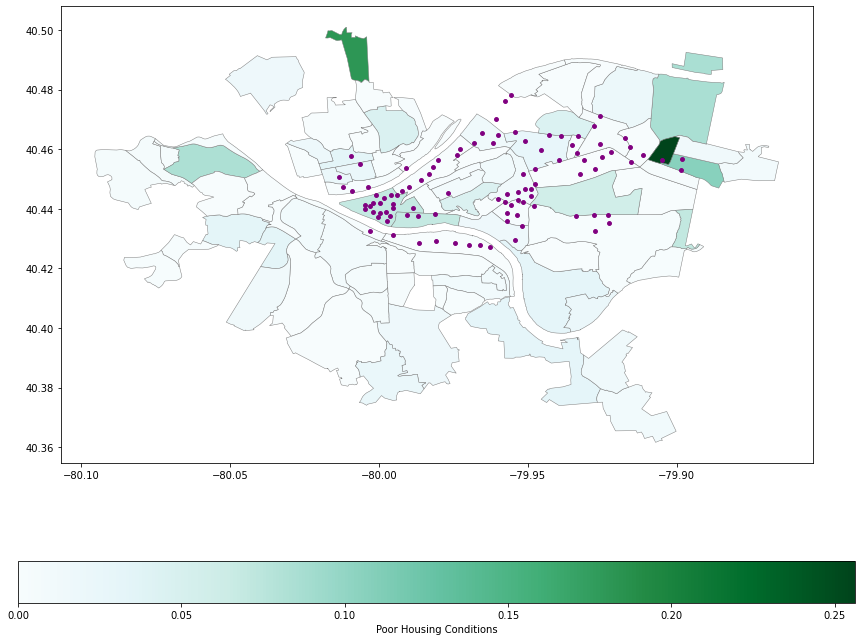

In [122]:
#plotting the poor housing condition data on the pittsburgh neighborhood map (data from 2016)
pdf.plot(column="poorCon", cmap='BuGn', figsize = (15, 12), edgecolor = "grey", linewidth = 0.5, legend=True, legend_kwds={'label': "Poor Housing Conditions",'orientation': "horizontal"})
#now adding the bike station location data on top of this map. 
plt.scatter(df['Longitude'], df['Latitude'], 15, marker='o', color='Purple')
plt.show()